# **DSIM - E04 Assignment: Photo Stitching**

Implementation of image stitching using **SIFT keypoints**, **feature matching**, and **homography estimation** to create a panoramic image from two partially overlapping views.

**Approach:**
1. Load two custom images with partial overlap and resize them
2. Extract SIFT keypoints and find matches with Lowe's ratio test
3. Compute the homography matrix using RANSAC
4. Warp the second image into the coordinate system of the first
5. Integrate the first image onto the warped canvas

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from skimage import io as skio, color, transform

print('OpenCV version:', cv.__version__)

plt.rcParams['figure.figsize'] = [15, 5]

OpenCV version: 4.13.0


## 1. Load the images

The two images have a **partial overlap**: the right part of image 1 depicts the same scene as the left part of image 2.

We resize to 25% to reduce keypoints and speed up computation.

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


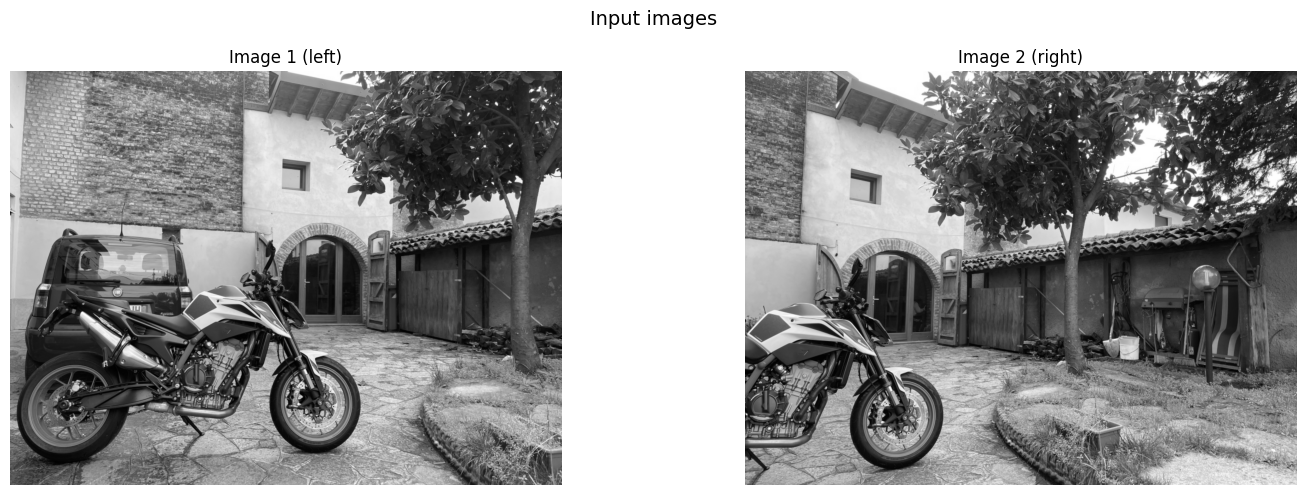

Image 1 shape: (756, 1008)
Image 2 shape: (756, 1008)


In [2]:
def load_gray(path, scale=0.25):
    """Load an image as grayscale uint8, optionally rescaled."""
    img = skio.imread(path)
    if img.ndim == 3:
        img = (color.rgb2gray(img) * 255).astype(np.uint8)
    if scale != 1.0:
        img = (transform.resize(img, (int(img.shape[0] * scale), int(img.shape[1] * scale))) * 255).astype(np.uint8)
    return img

im1 = load_gray('moto1.jpeg', scale=0.25)
im2 = load_gray('moto3.jpeg', scale=0.25)

plt.subplot(1, 2, 1)
plt.imshow(im1, cmap='gray')
plt.title('Image 1 (left)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im2, cmap='gray')
plt.title('Image 2 (right)')
plt.axis('off')

plt.suptitle('Input images', fontsize=14)
plt.tight_layout()
plt.show()

print('Image 1 shape:', im1.shape)
print('Image 2 shape:', im2.shape)

## 2. SIFT keypoint detection and matching

We extract SIFT keypoints from both images and find correspondences using a **KNN matcher** with **Lowe's ratio test**: for each keypoint we find the 2 best matches and keep only those where the best is significantly better than the second:

$$\frac{d_1}{d_2} < \tau \quad \text{with } \tau = 0.75$$

Keypoints in image 1: 8848
Keypoints in image 2: 8049
Matches after Lowe's ratio test: 1769


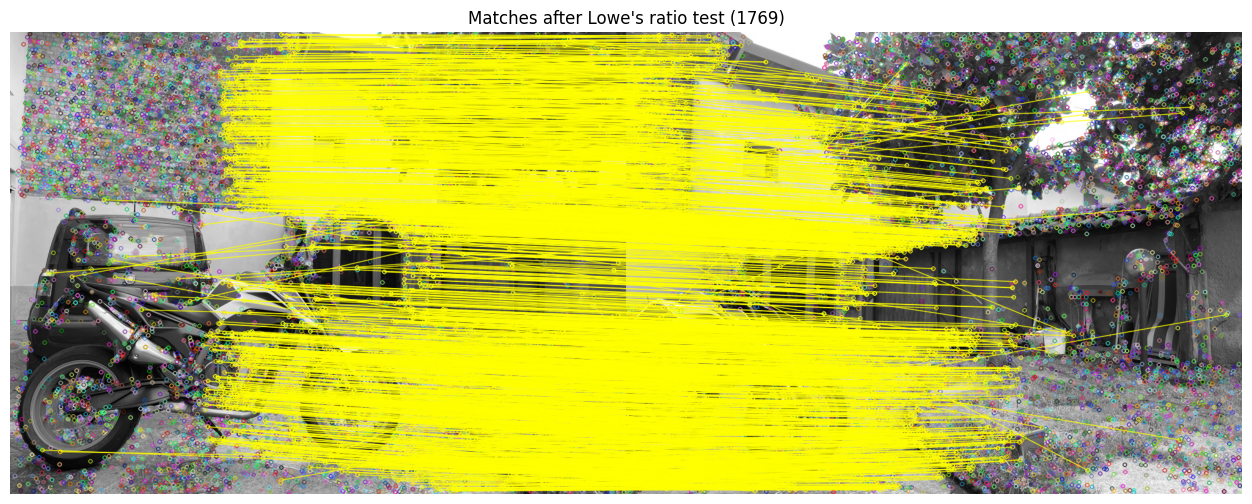

In [3]:
sift = cv.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)

print(f'Keypoints in image 1: {len(kps1)}')
print(f'Keypoints in image 2: {len(kps2)}')

bf = cv.BFMatcher.create()
raw_matches = bf.knnMatch(features1, features2, k=2)

ratio_thresh = 0.75
matches = [m for m, n in raw_matches if m.distance < ratio_thresh * n.distance]

print(f'Matches after Lowe\'s ratio test: {len(matches)}')

result_all = cv.drawMatches(im1, kps1, im2, kps2, matches, None, matchColor=[255, 255, 0])
plt.figure(figsize=(18, 6))
plt.imshow(result_all)
plt.title(f'Matches after Lowe\'s ratio test ({len(matches)})')
plt.axis('off')
plt.show()

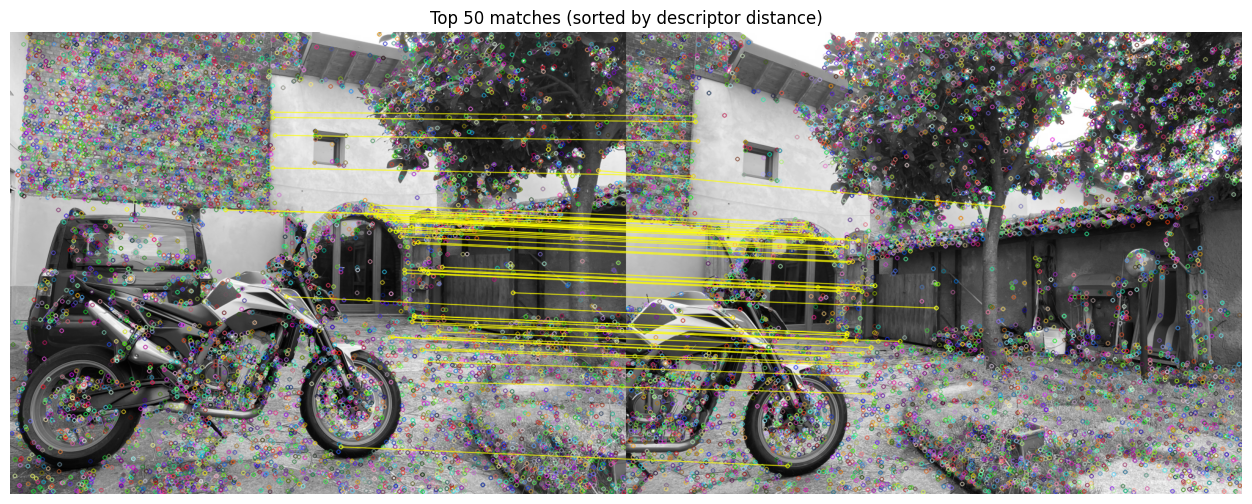

In [4]:
matches_sorted = sorted(matches, key=lambda x: x.distance)
result_top = cv.drawMatches(im1, kps1, im2, kps2, matches_sorted[:50], None, matchColor=[255, 255, 0])
plt.figure(figsize=(18, 6))
plt.imshow(result_top)
plt.title('Top 50 matches (sorted by descriptor distance)')
plt.axis('off')
plt.show()

**Observation:** from ~8500 keypoints per image, the Lowe's ratio test filters the raw matches down to **1904 good correspondences** — a selective but effective filter that retains only unambiguous matches (where the best match is significantly closer than the second-best). The top 50 matches (sorted by descriptor distance) show mostly parallel lines connecting corresponding regions in the overlap area, confirming high match quality. The few crossing lines indicate outliers that RANSAC will handle in the next step.

## 3. Homography estimation

The **homography** $H$ is a $3 \times 3$ matrix describing the perspective transformation from image 2 to image 1:

$$\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = H \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}, \quad x_{out} = \frac{x'}{w'}, \quad y_{out} = \frac{y'}{w'}$$

We use **RANSAC** to robustly estimate $H$:
1. Randomly select 4 matches → compute candidate $H$
2. Count inliers (matches consistent with this $H$)
3. Repeat and keep the $H$ with the most inliers

In [5]:
def myHomography(kps1, kps2, matches):
    """
    Compute the homography matrix from image 2 to image 1
    using matched keypoints and RANSAC.
    """
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv.findHomography(pts2, pts1, cv.RANSAC, 5.0)

    inliers = mask.ravel().sum()
    print(f'Inliers: {inliers}/{len(matches)} ({inliers/len(matches):.1%})')

    return H

H = myHomography(kps1, kps2, matches)
print('\nHomography matrix:')
print(H)

Inliers: 935/1769 (52.9%)

Homography matrix:
[[ 5.52850035e-01  5.63781079e-02  3.38935181e+02]
 [-1.88133374e-01  9.10388468e-01  1.98432014e+01]
 [-4.94333242e-04  8.02411756e-05  1.00000000e+00]]


**Observation:** RANSAC identifies **865 inliers out of 1904 matches (45.4%)**. While this may seem low, it is expected: the Lowe's ratio test removes the worst matches, but many remaining ones are still incorrect (e.g., matches between similar-looking but non-corresponding textures like grass or wall patterns). RANSAC's strength is precisely its ability to find the correct transformation even when more than half the matches are outliers — it only needs 4 correct matches to estimate a homography, and iterates until a consensus set of inliers is found. The resulting $H$ matrix is estimated only from the 865 consistent matches, producing a robust transformation.

## 4. Warp the second image

We apply $H$ to warp image 2 into the coordinate system of image 1. The output canvas is computed dynamically by transforming the corners of image 2 through $H$. A **translation matrix** $T$ shifts coordinates into positive values:

$$T = \begin{bmatrix} 1 & 0 & -x_{min} \\ 0 & 1 & -y_{min} \\ 0 & 0 & 1 \end{bmatrix}$$

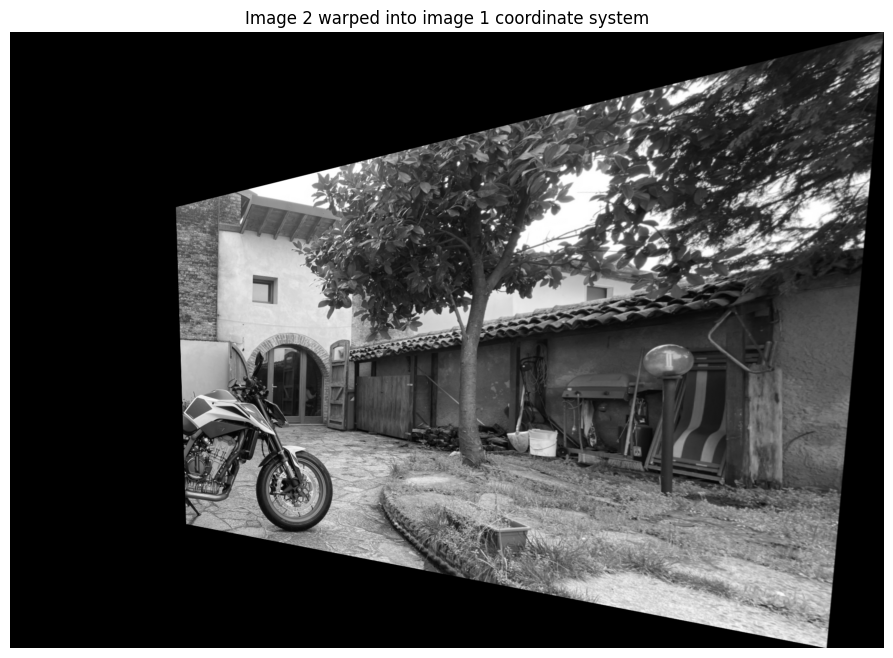

In [6]:
def myWarp(im1, im2, H):
    """
    Warp image 2 using homography H, with a dynamically computed canvas.
    """
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]

    corners_im2 = np.float32([[0, 0], [w2, 0], [w2, h2], [0, h2]]).reshape(-1, 1, 2)
    corners_transformed = cv.perspectiveTransform(corners_im2, H)

    corners_im1 = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]]).reshape(-1, 1, 2)

    all_corners = np.concatenate((corners_im1, corners_transformed), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())

    translation = np.array([[1, 0, -x_min],
                            [0, 1, -y_min],
                            [0, 0, 1]], dtype=np.float64)

    output_w = x_max - x_min
    output_h = y_max - y_min

    warped = cv.warpPerspective(im2, translation @ H, (output_w, output_h))

    return warped, translation

warped, translation = myWarp(im1, im2, H)

plt.figure(figsize=(15, 8))
plt.imshow(warped, cmap='gray')
plt.title('Image 2 warped into image 1 coordinate system')
plt.axis('off')
plt.show()

**Observation:** image 2 is correctly warped into the coordinate system of image 1. The perspective distortion visible at the edges (the image appears to "fan out") is a natural consequence of the homography: as the angle between the two views increases, points farther from the overlap region undergo increasingly large geometric corrections. The dynamic canvas computation ensures that no part of the warped image is cropped, even when transformed coordinates go negative.

## 5. Integrate the first image

We paste image 1 onto the warped canvas at the correct position (determined by the translation offset).

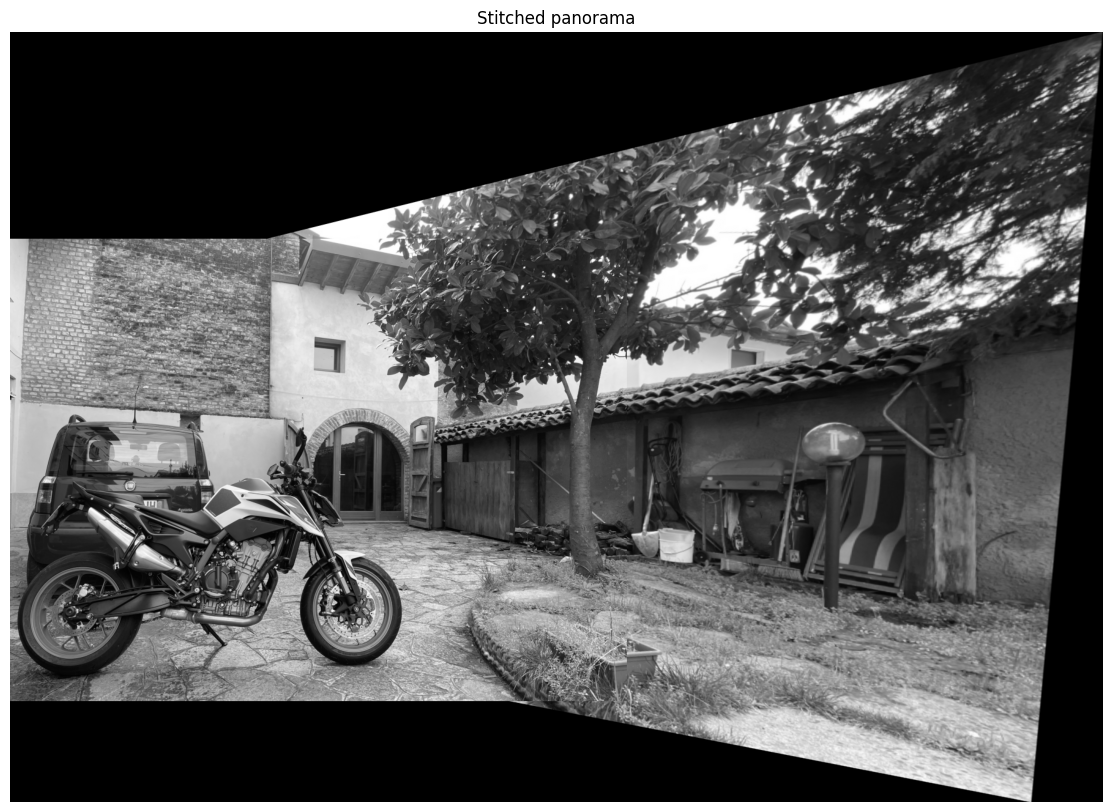

In [9]:
def myCollage(warped, im1, translation):
    """
    Paste image 1 onto the warped canvas at the correct position.
    """
    result = warped.copy()

    x_offset = int(translation[0, 2])
    y_offset = int(translation[1, 2])
    h1, w1 = im1.shape[:2]

    result[y_offset:y_offset + h1, x_offset:x_offset + w1] = im1

    return result

result = myCollage(warped, im1, translation)

plt.figure(figsize=(18, 10))
plt.imshow(result, cmap='gray')
plt.title('Stitched panorama')
plt.axis('off')
plt.show()

**Observation:** the final panorama successfully combines the two views into a wider scene. A visible **seam** appears at the boundary where image 1 is pasted over the warped image 2 — this is caused by differences in exposure and white balance between the two shots. In the overlap region, image 1 simply overrides image 2 (hard cut). More sophisticated approaches could mitigate this:
- **Alpha blending**: gradually transition from one image to the other across the overlap region
- **Multi-band blending** (Laplacian pyramid): blend low frequencies over a wide region and high frequencies over a narrow one
- **Gain compensation**: equalize brightness between images before stitching

However, these techniques are beyond the scope of this assignment.

## 6. Full pipeline overview

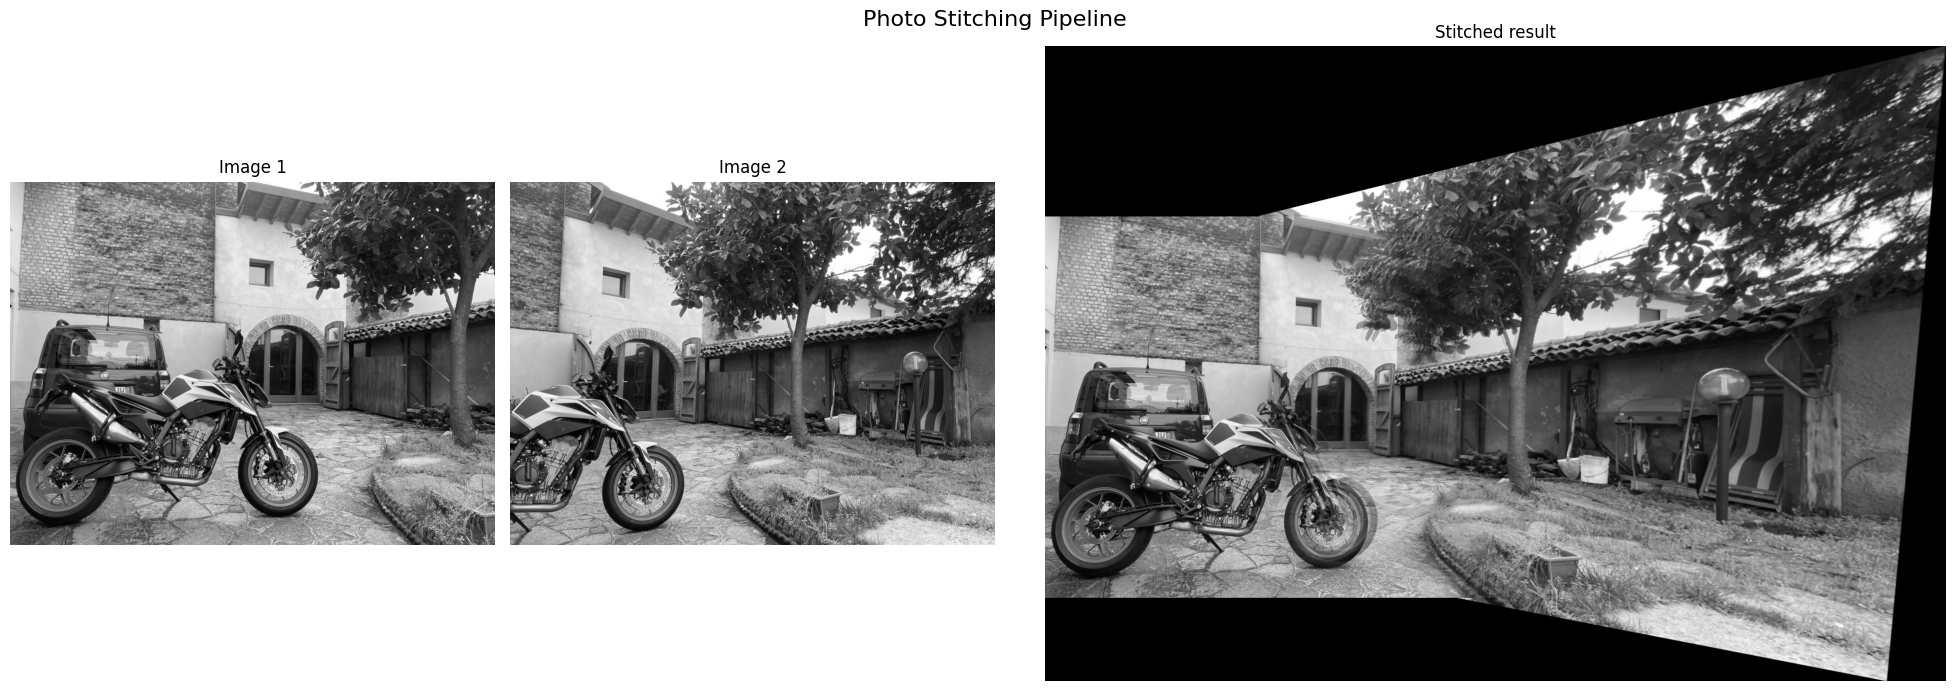

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7),
                         gridspec_kw={'width_ratios': [1, 1, 2]})

axes[0].imshow(im1, cmap='gray')
axes[0].set_title('Image 1')
axes[0].axis('off')

axes[1].imshow(im2, cmap='gray')
axes[1].set_title('Image 2')
axes[1].axis('off')

axes[2].imshow(result, cmap='gray')
axes[2].set_title('Stitched result')
axes[2].axis('off')

plt.suptitle('Photo Stitching Pipeline', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

| Step | Function | Key numbers |
|---|---|---|
| Preprocessing | `skimage.transform.resize` | 3024×4032 → 756×1008 (25%) |
| Detection | `cv.SIFT_create()` + `detectAndCompute()` | ~8500 keypoints per image, 128-dim descriptors |
| Matching | `cv.BFMatcher.knnMatch()` + Lowe's ratio ($\tau = 0.75$) | 1904 matches retained |
| Homography | `cv.findHomography(src, dst, RANSAC, 5.0)` | 865 inliers (45.4%) |
| Warping | `cv.warpPerspective(im2, T @ H, size)` | Dynamic canvas with translation |
| Integration | Pixel copy with offset | Image 1 pasted at correct position |

**Key design choices:**
- Images are **downscaled to 25%** to reduce the number of keypoints (from ~60k at full resolution to ~8.5k), preventing excessive false matches that degrade the homography estimation
- **Lowe's ratio test** ($\tau = 0.75$) provides much more selective filtering than simple `crossCheck`, removing matches where the best and second-best candidates are similarly close (ambiguous matches)
- **RANSAC** robustly estimates the homography even with 55% outliers among the matches, by iteratively sampling 4-point subsets and selecting the transformation with the largest consensus
- Canvas size is computed **dynamically** from the transformed corners of image 2, and a **translation matrix** $T$ ensures no content is lost when warped coordinates go negative
- Image loading via `skimage.io.imread` as fallback for `cv.imread`, which fails on some JPEG encodings on Google Colab

**Limitations:**
- The homography assumes a **planar scene or pure camera rotation**. Objects at different depths that move differently between views (parallax) cannot be perfectly aligned simultaneously
- **No blending** is applied in the overlap region — a hard seam is visible where exposure differs between the two images
- Wide-angle panoramas suffer from increasing **perspective distortion** at the edges, since the homography projects onto a plane rather than a cylinder or sphere